In [161]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [162]:
path_main = 'FS-data-80475.csv'
path_2025 = 'FS-data-80475-2025-all-months.csv'
path_sample = 'sample_data.csv'


In [163]:
df_main = pd.read_csv(path_main)
df_2025 = pd.read_csv(path_2025)

In [164]:
df = pd.concat([df_main, df_2025], ignore_index=True)

In [165]:
df

,account_id,english_name,dealer_code,year,month,monthly_value,yearly_value
0,40000U,TOTAL MITSUBISHI CARS RETAIL (LINES 2 THRU 4),80475,2022,1,1.00,1.00
1,6097DZ,Used Retail to Wholesale Ratio,80475,2022,1,0.00,0.00
2,46000U,TOTAL BODY SHOP DEPT. (LINES 30 THRU 35),80475,2022,1,0.00,0.00
3,6093DZ,UV Units Sold Per NV & UV Sales Rep.,80475,2022,1,0.00,0.00
4,6089DZ,Used Retail to Wholesale Ratio,80475,2022,1,6.00,6.00
...,...,...,...,...,...,...,...
55003,6002DZ,Pts. Sls. per Customer RO (Inc. Tires),80475,2024,12,22.39,246.97
55004,8274D,Data Processing,80475,2024,12,-9273.00,4487.00
55005,8444D,Repairs & Maintenance - Real Estate,80475,2024,12,-2389.00,-463.00
55006,5041D,Warranty Labour Rate,80475,2024,12,0.00,0.00


In [166]:
df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'].astype(str) + '-01')

In [167]:
df = df.sort_values(['english_name', 'account_id', 'date']).reset_index(drop=True)

In [168]:
df.head()

,account_id,english_name,dealer_code,year,month,monthly_value,yearly_value,date
0,8503D,Bonuses - Employees,80475,2022,1,0.0,0.0,2022-01-01
1,8503D,Bonuses - Employees,80475,2022,2,0.0,0.0,2022-02-01
2,8503D,Bonuses - Employees,80475,2022,3,0.0,0.0,2022-03-01
3,8503D,Bonuses - Employees,80475,2022,4,0.0,0.0,2022-04-01
4,8503D,Bonuses - Employees,80475,2022,5,0.0,0.0,2022-05-01


In [169]:
cleaned = []

for (kpi, acc), grp in df.groupby(['english_name', 'account_id']):
    # Remove duplicates before setting the index
    grp = grp.drop_duplicates(subset=['date']).copy()

    # full date range banao
    full_range = pd.date_range(grp['date'].min(), grp['date'].max(), freq='MS')
    grp = grp.set_index('date').reindex(full_range).reset_index()
    grp = grp.rename(columns={'index': 'date'})

    # KPI info fill
    grp['english_name'] = kpi
    grp['account_id'] = acc

    cleaned.append(grp)

df_filled = pd.concat(cleaned, ignore_index=True)

In [170]:
def detect_outliers(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    return ((series < lower) | (series > upper))

df_filled['is_outlier'] = df_filled.groupby(['english_name','account_id'])['monthly_value']\
                                   .transform(detect_outliers)


In [171]:
df_filled.head()

,date,account_id,english_name,dealer_code,year,month,monthly_value,yearly_value,is_outlier
0,2022-01-01,8503D,Bonuses - Employees,80475,2022,1,0.0,0.0,False
1,2022-02-01,8503D,Bonuses - Employees,80475,2022,2,0.0,0.0,False
2,2022-03-01,8503D,Bonuses - Employees,80475,2022,3,0.0,0.0,False
3,2022-04-01,8503D,Bonuses - Employees,80475,2022,4,0.0,0.0,False
4,2022-05-01,8503D,Bonuses - Employees,80475,2022,5,0.0,0.0,False


In [172]:
df_filled['year'] = df_filled['date'].dt.year

df_filled['ytd_value'] = df_filled.groupby(['english_name','account_id','year'])['monthly_value']\
                                  .cumsum()

In [173]:
df_filled.to_csv("clean.csv", index=False)


In [174]:
df_feat = df_filled.copy()

df_feat['month_num'] = df_feat['date'].dt.month
df_feat['quarter'] = df_feat['date'].dt.quarter
df_feat['year'] = df_feat['date'].dt.year
df_feat['is_year_end'] = (df_feat['month_num'] == 12).astype(int)


In [175]:
for lag in [1, 3, 12]:
    df_feat[f'lag_{lag}'] = df_feat.groupby(['english_name','account_id'])['monthly_value'].shift(lag)


In [176]:
for window in [3, 6, 12]:
    df_feat[f'roll_mean_{window}'] = df_feat.groupby(['english_name','account_id'])['monthly_value']\
                                             .transform(lambda x: x.rolling(window).mean())
    df_feat[f'roll_std_{window}'] = df_feat.groupby(['english_name','account_id'])['monthly_value']\
                                            .transform(lambda x: x.rolling(window).std())


In [177]:
df_feat['ytd_value_lag1'] = df_feat.groupby(['english_name','account_id','year'])['ytd_value'].shift(1)


In [178]:
df_feat.to_csv("features/feature_matrix.csv", index=False)


In [179]:
def naive_forecast(series, horizon=3):
    last_val = series.iloc[-1]
    return [last_val] * horizon


In [180]:
def moving_avg_forecast(series, horizon=3, window=3):
    avg_val = series.tail(window).mean()
    return [avg_val] * horizon


In [181]:
import numpy as np

def seasonal_naive_forecast(series, horizon=3):
    if len(series) < 12:
        return [np.nan] * horizon
    return [series.iloc[-12+i] for i in range(horizon)]


In [182]:
from sklearn.metrics import mean_absolute_percentage_error

def backtest(series, model_func, horizon=3, min_train=15):
    errors = []
    for i in range(min_train, len(series)-horizon):
        train = series[:i]
        test = series[i:i+horizon]
        pred = model_func(train, horizon)
        if np.isnan(pred).any():
            continue
        err = mean_absolute_percentage_error(test, pred)
        errors.append(err)
    return np.mean(errors) if errors else np.nan


In [183]:
results = []

for (kpi, acc), grp in df_feat.groupby(['english_name','account_id']):
    series = grp.set_index('date')['monthly_value'].dropna()
    if len(series) < 15:
        continue

    naive_mape = backtest(series, naive_forecast)
    ma_mape = backtest(series, moving_avg_forecast)
    snaive_mape = backtest(series, seasonal_naive_forecast)

    results.append({
        "english_name": kpi,
        "account_id": acc,
        "naive_mape": naive_mape,
        "moving_avg_mape": ma_mape,
        "seasonal_naive_mape": snaive_mape
    })

baseline_results = pd.DataFrame(results)
baseline_results.to_csv("Reports/baseline_cv.csv", index=False)


In [184]:
final_preds = []

for (kpi, acc), grp in df_feat.groupby(['english_name','account_id']):
    series = grp.set_index('date')['monthly_value'].dropna()
    if len(series) < 15:
        continue

    pred = moving_avg_forecast(series, horizon=3, window=3)  # default best simple model
    last_date = series.index[-1]
    future_dates = pd.date_range(last_date + pd.offsets.MonthBegin(), periods=3, freq='MS')

    for ds, y_hat in zip(future_dates, pred):
        final_preds.append({
            "english_name": kpi,
            "account_id": acc,
            "ds": ds,
            "y_hat": y_hat
        })

pred_df = pd.DataFrame(final_preds)
pred_df.to_csv("deliverables/predictions_baseline.csv", index=False)


In [185]:
import pandas as pd

baseline_results = pd.read_csv("Reports/baseline_cv.csv")


In [186]:
def get_best_model(row):
    scores = {
        "naive": row["naive_mape"],
        "moving_avg": row["moving_avg_mape"],
        "seasonal_naive": row["seasonal_naive_mape"]
    }
    # nan ignore karke best choose karna
    best = min((v,k) for k,v in scores.items() if not pd.isna(v))
    return best[1]

baseline_results["best_model"] = baseline_results.apply(get_best_model, axis=1)


In [189]:
baseline_results.to_csv("Reports/model_leaderboard.csv", index=False)


In [192]:
model_registry = {}

for _, row in baseline_results.iterrows():
    # Convert the tuple key to a string
    key = f"{row['english_name']}_{row['account_id']}"
    model_registry[key] = row["best_model"]

import json
with open("models/registry.json", "w") as f:
    json.dump(model_registry, f, indent=4)

In [194]:
import pandas as pd

# KPI pivot: rows = date (date), columns = english_name, values = monthly_value
kpi_pivot = df_feat.pivot_table(
    index="date",
    columns="english_name",
    values="monthly_value",
    aggfunc="mean"
)


In [196]:
corr_matrix = kpi_pivot.corr(method="pearson")
corr_matrix.to_csv("Reports/correlation_matrix.csv")


In [198]:
def lagged_corr(x, y, lag=1):
    return x.corr(y.shift(lag))

lagged_results = []

for col1 in kpi_pivot.columns:
    for col2 in kpi_pivot.columns:
        if col1 == col2:
            continue
        corr_val = lagged_corr(kpi_pivot[col1], kpi_pivot[col2], lag=1)
        lagged_results.append({
            "driver": col1,
            "dependent": col2,
            "lag": 1,
            "corr": corr_val
        })

lagged_df = pd.DataFrame(lagged_results)
lagged_df.to_csv("Reports/lagged_correlations.csv", index=False)


In [200]:
influence = lagged_df.groupby("dependent").apply(
    lambda g: g.nlargest(3, "corr")  # top 3 drivers
).reset_index(drop=True)

influence.to_csv("Reports/influence_matrix.csv", index=False)


In [207]:
import plotly.express as px

fig = px.imshow(corr_matrix,
                color_continuous_scale="RdBu_r",
                title="Interactive KPI Correlation Heatmap")
fig.write_html("Reports/correlation_heatmap.html")
fig.show()


In [212]:
import pandas as pd

def apply_scenario(baseline_df, changes_dict, influence_matrix, steps=1):
    """
    baseline_df: DataFrame with ['ds','english_name','y_hat']
    changes_dict: { (kpi, date): percentage_change } e.g. {("Sales","2025-03-01"): 0.1}
    influence_matrix: DataFrame with ['driver','dependent','corr']
    steps: how many propagation steps to apply
    """

    df = baseline_df.copy()

    # apply direct changes
    for (kpi, date), change in changes_dict.items():
        mask = (df['english_name'] == kpi) & (df['ds'] == pd.to_datetime(date))
        df.loc[mask, 'y_hat'] *= (1 + change)

    # propagate changes
    for step in range(steps):
        new_changes = {}
        for (kpi, date), change in changes_dict.items():
            affected = influence_matrix[influence_matrix['driver'] == kpi]
            for _, row in affected.iterrows():
                dep = row['dependent']
                weight = row['corr']
                dep_change = change * weight  # proportional effect
                mask = (df['english_name'] == dep) & (df['ds'] == pd.to_datetime(date))
                df.loc[mask, 'y_hat'] *= (1 + dep_change)
                new_changes[(dep, date)] = dep_change
        changes_dict.update(new_changes)

    return df

In [213]:
# Suppose baseline forecast
baseline_df = pd.DataFrame({
    "ds": pd.to_datetime(["2025-03-01","2025-03-01"]),
    "english_name": ["Sales","Profit"],
    "y_hat": [1000, 200]
})

# Example influence matrix
influence_matrix = pd.DataFrame({
    "driver":["Sales"],
    "dependent":["Profit"],
    "corr":[0.6]   # positive relation
})

# Scenario: Sales +10% in March 2025
changes = {("Sales","2025-03-01"): 0.1}

updated = apply_scenario(baseline_df, changes, influence_matrix)
print(updated)


          ds english_name  y_hat
0 2025-03-01        Sales   1100
1 2025-03-01       Profit    212


In [214]:
import numpy as np

# Naïve Forecast → last value repeat karo
def naive_forecast(series, horizon=3):
    last_val = series.iloc[-1]
    return [last_val] * horizon

# Moving Average Forecast → last N months ka average repeat karo
def moving_avg_forecast(series, horizon=3, window=3):
    avg_val = series.tail(window).mean()
    return [avg_val] * horizon

# Seasonal Naïve → pichle saal ke same month ki value
def seasonal_naive_forecast(series, horizon=3, season=12):
    if len(series) < season:
        return [np.nan] * horizon
    return [series.iloc[-season+i] for i in range(horizon)]


In [215]:
from sklearn.metrics import mean_absolute_percentage_error

def backtest(series, model_func, horizon=3, min_train=15, **kwargs):
    errors = []
    for i in range(min_train, len(series)-horizon):
        train = series[:i]
        test = series[i:i+horizon]
        pred = model_func(train, horizon=horizon, **kwargs)
        if np.isnan(pred).any():
            continue
        err = mean_absolute_percentage_error(test, pred)
        errors.append(err)
    return np.mean(errors) if errors else np.nan


In [219]:
results = []

for (kpi, acc), grp in df_feat.groupby(['english_name','account_id']):
    series = grp.set_index('date')['monthly_value'].dropna()
    if len(series) < 15:
        continue

    # 3 models ke MAPE
    naive_mape = backtest(series, naive_forecast)
    ma_mape = backtest(series, moving_avg_forecast)
    snaive_mape = backtest(series, seasonal_naive_forecast)

    # best model choose karo
    score_map = {
        "naive": naive_mape,
        "moving_avg": ma_mape,
        "seasonal_naive": snaive_mape
    }
    best_model = min(score_map, key=lambda k: score_map[k] if score_map[k] is not None else np.inf)

    results.append({
        "english_name": kpi,
        "account_id": acc,
        "naive_mape": naive_mape,
        "moving_avg_mape": ma_mape,
        "seasonal_naive_mape": snaive_mape,
        "best_model": best_model
    })

leaderboard = pd.DataFrame(results)
leaderboard.to_csv("Reports/model_leaderboard_kpi.csv", index=False)


In [221]:
preds = []

for (kpi, acc), grp in df_feat.groupby(['english_name','account_id']):
    series = grp.set_index('date')['monthly_value'].dropna()
    if len(series) < 15:
        continue

    # best model pick from leaderboard
    row = leaderboard[(leaderboard['english_name']==kpi) &
                      (leaderboard['account_id']==acc)].iloc[0]
    model = row['best_model']

    if model == "naive":
        forecast = naive_forecast(series, horizon=3)
    elif model == "moving_avg":
        forecast = moving_avg_forecast(series, horizon=3)
    else:
        forecast = seasonal_naive_forecast(series, horizon=3)

    last_date = series.index[-1]
    future_dates = pd.date_range(last_date + pd.offsets.MonthBegin(), periods=3, freq='MS')

    for ds, y_hat in zip(future_dates, forecast):
        preds.append({
            "english_name": kpi,
            "account_id": acc,
            "ds": ds,
            "y_hat": y_hat,
            "model_used": model
        })

pred_df = pd.DataFrame(preds)
pred_df.to_csv("deliverables/predictions_3m.csv", index=False)


In [222]:
def train_test_split_series(series, test_size=3):
    return series[:-test_size], series[-test_size:]


In [223]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np

def evaluate_model(series, model_func, horizon=3):
    train, test = train_test_split_series(series, test_size=horizon)
    preds = model_func(train, horizon)

    mae = mean_absolute_error(test, preds)
    rmse = np.sqrt(mean_squared_error(test, preds))
    mape = mean_absolute_percentage_error(test, preds)

    return {"MAE": mae, "RMSE": rmse, "MAPE": mape}


In [225]:
results = []

for (kpi, acc), grp in df_feat.groupby(['english_name','account_id']):
    series = grp.set_index('date')['monthly_value'].dropna()
    if len(series) < 20:
        continue

    # example with Moving Average
    metrics = evaluate_model(series, lambda s,h: moving_avg_forecast(s,h,window=3))
    metrics["english_name"] = kpi
    metrics["account_id"] = acc
    results.append(metrics)

acc_df = pd.DataFrame(results)
acc_df.to_csv("Reports/final_accuracy.csv", index=False)


In [226]:
acc_df.head()

,MAE,RMSE,MAPE,english_name,account_id
0,0.000000,0.000000,0.000000e+00,Bonuses - Employees,8503D
1,0.494444,0.604639,1.008182e+00,NV Months Supply (Guide 2.5 months),6063DZ
2,0.000000,0.000000,0.000000e+00,Taxes - Other,8403D
3,3.500000,4.038014,2.752200e+15,UV Units Sold Per UV Sales Rep.,6076DZ
4,0.000000,0.000000,0.000000e+00,# of Productive Bays,50001SD


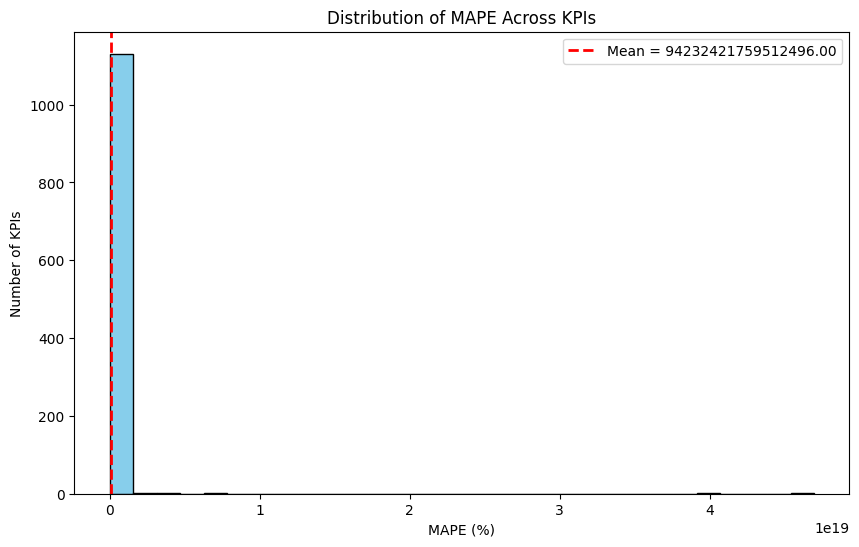

Top 10 Best KPIs (Lowest Error):
                   english_name  MAPE
437             Goodwill Policy   0.0
422           Freight & Express   0.0
424       Furnitures & Fixtures   0.0
426  Gain on Disposal of Assets   0.0
427           Gas, Oil & Grease   0.0
428           Gas, Oil & Grease   0.0
429           Gas, Oil & Grease   0.0
430          Gas, Oil, & Grease   0.0
433             Goodwill Policy   0.0
434             Goodwill Policy   0.0
Top 10 Worst KPIs (Highest Error):
                    english_name          MAPE
152             Bldgs. & Improv.  4.696053e+19
171   Buildings & \nImprovements  3.916030e+19
153             Bldgs. & Improv.  7.800235e+18
996          Taxes - Real Estate  3.588869e+18
1049      Travel & Entertainment  1.943553e+18
997          Taxes - Real Estate  1.256004e+18
999          Taxes - Real Estate  1.256004e+18
1050      Travel & Entertainment  9.407519e+17
231      Company Vehicle Expense  8.261603e+17
1052     Travel & Entertainment   8.106479e+

In [229]:
# 1) Load accuracy results
acc_df = pd.read_csv("Reports/final_accuracy.csv")

# 2) Histogram of MAPE
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.hist(acc_df["MAPE"].dropna(), bins=30, color="skyblue", edgecolor="black")
plt.xlabel("MAPE (%)")
plt.ylabel("Number of KPIs")
plt.title("Distribution of MAPE Across KPIs")
plt.axvline(acc_df["MAPE"].mean(), color="red", linestyle="dashed", linewidth=2,
            label=f"Mean = {acc_df['MAPE'].mean():.2f}")
plt.legend()
plt.show()

# 3) Top 10 best KPIs
best_kpis = acc_df.sort_values("MAPE").head(10)
print("Top 10 Best KPIs (Lowest Error):")
print(best_kpis[["english_name","MAPE"]])

# 4) Top 10 worst KPIs
worst_kpis = acc_df.sort_values("MAPE", ascending=False).head(10)
print("Top 10 Worst KPIs (Highest Error):")
print(worst_kpis[["english_name","MAPE"]])

# 5) Save reports
best_kpis.to_csv("Reports/top10_best_kpis.csv", index=False)
worst_kpis.to_csv("Reports/top10_worst_kpis.csv", index=False)


In [231]:
!zip -r project.zip Reports deliverables models features data_clean
from google.colab import files
files.download("project.zip")


	zip warning: name not matched: data_clean
  adding: Reports/ (stored 0%)
  adding: Reports/baseline_cv.csv (deflated 65%)
  adding: Reports/top10_worst_kpis.csv (deflated 49%)
  adding: Reports/correlation_matrix.csv (deflated 58%)
  adding: Reports/.ipynb_checkpoints/ (stored 0%)
  adding: Reports/lagged_correlations.csv (deflated 81%)
  adding: Reports/influence_matrix.csv (deflated 80%)
  adding: Reports/model_leaderboard_kpi.csv (deflated 68%)
  adding: Reports/model_leaderboard.csv (deflated 68%)
  adding: Reports/top10_best_kpis.csv (deflated 56%)
  adding: Reports/final_accuracy.csv (deflated 69%)
  adding: Reports/correlation_heatmap.html (deflated 68%)
  adding: deliverables/ (stored 0%)
  adding: deliverables/predictions_baseline.csv (deflated 89%)
  adding: deliverables/predictions_3m.csv (deflated 89%)
  adding: models/ (stored 0%)
  adding: models/registry.json (deflated 84%)
  adding: features/ (stored 0%)
  adding: features/feature_matrix.csv (deflated 80%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>